In [1]:
import cv2,os
import numpy as np
from keras.utils import np_utils
from keras.models import Sequential
from keras.layers import  Dense, Activation, Dropout, Conv2D, Flatten, MaxPooling2D
from keras.callbacks import ModelCheckpoint
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt
from keras.models import load_model

In [2]:
data_path = r'C:\Users\Vikash Kumar\Desktop\Deep Learning\Dataset'
categories = os.listdir(data_path)
labels = [i for i in range(len(categories))]
label_dict = dict(zip(categories,labels))
print(label_dict)
print(categories)
print(labels)

{'without_mask': 0, 'with_mask': 1}
['without_mask', 'with_mask']
[0, 1]


In [3]:
img_size = 150
data = []
target = []
for category in categories:
    folder_path = os.path.join(data_path,category) 
    img_names = os.listdir(folder_path)
    
    for img_name in img_names:
        img_path = os.path.join(folder_path,img_name)
        img = cv2.imread(img_path)
        try:
            gray = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
            resized = cv2.resize(gray,(img_size,img_size))
            data.append(resized)
            target.append(label_dict[category])
        
        except Exception as e:
            print("Exception: ",e)

In [4]:
data = np.array(data)/255.0
data = np.reshape(data,(data.shape[0],img_size,img_size,1))
target = np.array(target)
new_target = np_utils.to_categorical(target)
np.save('data',data)
np.save('target',new_target)

In [5]:
data = np.load('data.npy')
target = np.load('target.npy')
model = Sequential()
model.add(Conv2D(200,(3,3),input_shape=data.shape[1:]))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Conv2D(100,(3,3)))
model.add(Activation('relu'))
model.add(MaxPooling2D(pool_size=(2,2)))
model.add(Flatten())
model.add(Dropout(0.5))
model.add(Dense(50,activation='relu'))
model.add(Dense(2,activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics = ['acc'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 148, 148, 200)     2000      
_________________________________________________________________
activation (Activation)      (None, 148, 148, 200)     0         
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 74, 74, 200)       0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 72, 72, 100)       180100    
_________________________________________________________________
activation_1 (Activation)    (None, 72, 72, 100)       0         
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 36, 36, 100)       0         
_________________________________________________________________
flatten (Flatten)            (None, 129600)            0

In [6]:
train_data, test_data, train_target, test_target = train_test_split(data, target, test_size=0.1)


In [7]:
checkpoint=ModelCheckpoint('model-{epoch:03d}.model', monitor='val_loss', verbose = 0, save_best_only = True,mode='auto')
history = model.fit(train_data,train_target,epochs = 20, callbacks = [checkpoint], validation_split = 0.2)

Epoch 1/20
31/31 [==============================] - ETA: 0s - loss: 0.8758 - acc: 0.4919WARNING:tensorflow:From c:\users\vikash kumar\appdata\local\programs\python\python38\lib\site-packages\tensorflow\python\training\tracking\tracking.py:111: Model.state_updates (from tensorflow.python.keras.engine.training) is deprecated and will be removed in a future version.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
Instructions for updating:
This property should not be used in TensorFlow 2.0, as updates are applied automatically.
INFO:tensorflow:Assets written to: model-001.model\assets
31/31 [==============================] - 97s 3s/step - loss: 0.8758 - acc: 0.4919 - val_loss: 0.6923 - val_acc: 0.5927
Epoch 2/20
31/31 [==============================] - 98s 3s/step - loss: 0.6820 - acc: 0.6374 - val_loss: 0.6165 - val_acc: 0.6855
Epoch 3/20
31/31 [==============================] - 88s 3s/step - loss: 0.5790 - acc: 0.6980 

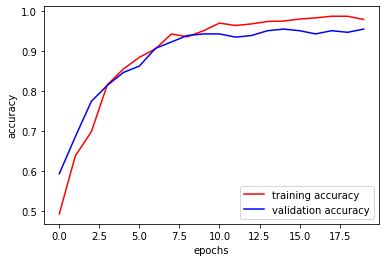

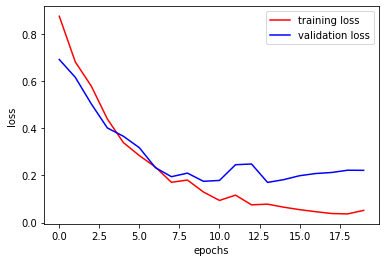

In [8]:
plt.plot(history.history['acc'],'r',label='training accuracy')
plt.plot(history.history['val_acc'],'b',label='validation accuracy')
plt.xlabel('epochs')
plt.ylabel('accuracy')
plt.legend()
plt.show()
plt.plot(history.history['loss'],'r',label='training loss')
plt.plot(history.history['val_loss'],'b',label='validation loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.legend()
plt.show()

In [9]:
print(model.evaluate(test_data,test_target))


5/5 [==============================] - 3s 537ms/step - loss: 0.1761 - acc: 0.9710
[0.17613959312438965, 0.9710144996643066]


In [11]:
#model = load_model('model-020.model')
faceCascade=cv2.CascadeClassifier(r'C:\Users\Vikash Kumar\Desktop\Deep Learning\haarcascade_frontalface_default.xml')
video_capture = cv2.VideoCapture(0)  
labels_dict = {0:'NO MASK',1:'MASK'}
color_dict  = { 0:(0,0,255),1:(0,255,0)}
img_size = 150


In [ ]:
while(True):
    ret,frame = video_capture.read()
    gray = cv2.cvtColor(frame,cv2.COLOR_BGR2GRAY)
    faces = faceCascade.detectMultiScale(gray,1.3,5)
    
    for x,y,w,h in faces:
        face_img = gray[y:y+w,x:x+h]
        resized = cv2.resize(face_img,(img_size,img_size))
        normalized = resized/255.0
        reshaped = np.reshape(normalized,(1,img_size,img_size,1))
        result = model.predict(reshaped)
        
        label = np.argmax(result,axis=1)[0]
        cv2.rectangle(frame,(x,y),(x+w,y+h),color_dict[label],2)
        cv2.putText(frame,labels_dict[label],(x,y-10),cv2.FONT_HERSHEY_SIMPLEX,0.8,(255,255,255),2)
        
    cv2.imshow('Video',frame)
    key=cv2.waitKey(1)
    
    if(key==27):
        break;
        
cv2.destroyAllWindows()
video_capture.release()